# [**Régression des processus gaussiens : exemple introductif de base**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/1_7_gaussian_process/plot_gpr_noisy_targets.ipynb)<br/>([_Gaussian Processes regression: basic introductory example_](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html))

Un exemple de régression unidimensionnelle simple calculé de deux manières différentes :
1. Cas sans bruit
2. Cas bruité avec un niveau de bruit connu par point de données

Dans les deux cas, les paramètres du noyau sont estimés en utilisant le principe du maximum de vraisemblance.

Les graphiques illustrent la propriété d'interpolation du modèle de processus gaussien ainsi que sa nature probabiliste sous la forme d'un intervalle de confiance à 95 % ponctuel.

Notez que `alpha` est un paramètre pour contrôler la force de la régularisation de Tikhonov sur la matrice de covariance des points d'entraînement supposés.

In [ ]:
# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#         Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause

# Génération du jeu de données

Nous commencerons par générer un jeu de données synthétique. Le véritable processus générateur est défini comme $f(x) = x \sin(x)$.

In [1]:
import numpy as np

X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)
y = np.squeeze(X * np.sin(X))

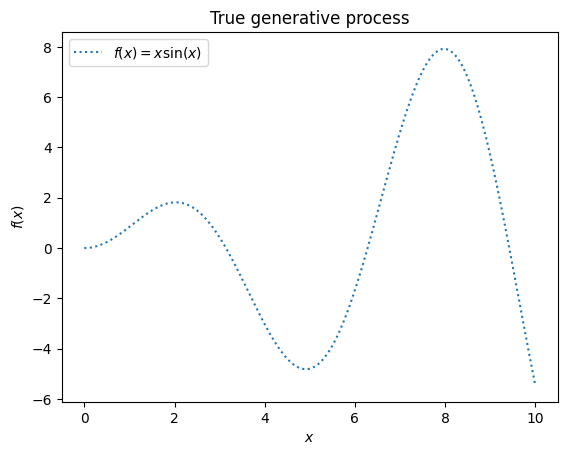

In [2]:
import matplotlib.pyplot as plt

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

Nous utiliserons ce jeu de données dans l'expérience suivante pour illustrer le fonctionnement de la régression des processus gaussiens.

# Exemple avec une cible sans bruit

Dans cet exemple, nous utiliserons le véritable processus générateur sans ajouter de bruit. Pour entraîner la régression des processus gaussiens, nous ne sélectionnerons que quelques échantillons.

In [3]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=6, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

Maintenant, nous ajustons un processus gaussien sur ces quelques échantillons de données d'entraînement. Nous utiliserons un noyau de fonction de base radiale (RBF) et un paramètre constant pour ajuster l'amplitude.

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

5.02**2 * RBF(length_scale=1.43)

Après avoir ajusté notre modèle, nous constatons que les hyperparamètres du noyau ont été optimisés. Maintenant, nous utiliserons notre noyau pour calculer la prédiction moyenne de l'ensemble complet de données et tracer l'intervalle de confiance à 95 %.

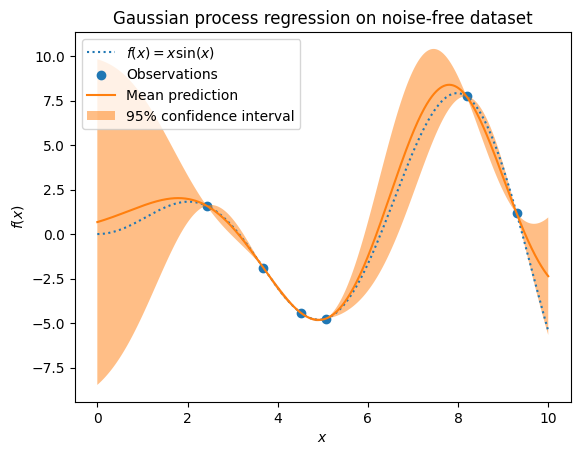

In [5]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

Nous constatons que pour une prédiction effectuée sur un point de données proche de celui de l'ensemble d'entraînement, l'intervalle de confiance à 95 % a une faible amplitude. Chaque fois qu'un échantillon s'éloigne des données d'entraînement, la prédiction de notre modèle est moins précise et la précision de la prédiction du modèle est moins précise (incertitude plus élevée).

Exemple avec des cibles bruitées

Nous pouvons répéter une expérience similaire en ajoutant un bruit supplémentaire à la cible cette fois-ci. Cela permettra de voir l'effet du bruit sur le modèle ajusté.

Nous ajoutons un bruit gaussien aléatoire à la cible avec un écart type arbitraire.

In [6]:
noise_std = 0.75
y_train_noisy = y_train + rng.normal(loc=0.0, scale=noise_std, size=y_train.shape)

Nous créons un modèle de processus gaussien similaire. En plus du noyau, cette fois-ci, nous spécifions le paramètre `alpha` qui peut être interprété comme la variance d'un bruit gaussien.

In [7]:
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_std**2, n_restarts_optimizer=9
)
gaussian_process.fit(X_train, y_train_noisy)
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

Traçons maintenant la prédiction moyenne et la région d'incertitude comme précédemment.

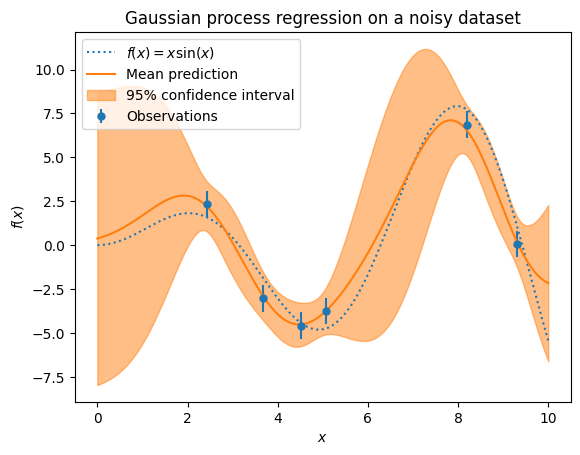

: 

In [8]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.errorbar(
    X_train,
    y_train_noisy,
    noise_std,
    linestyle="None",
    color="tab:blue",
    marker=".",
    markersize=10,
    label="Observations",
)
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

Le bruit affecte les prédictions près des échantillons d'entraînement : l'incertitude prédictive près des échantillons d'entraînement est plus grande car nous modélisons explicitement un certain niveau de bruit cible indépendant de la variable d'entrée.